In [1]:
import pandas as pd
from math import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from random import sample
import utils
from utils import shuffling
from utils import normalization
from utils import traintestsplit
from utils import feature_extract
import os

In [2]:
epilepsy_data = pd.read_csv("bonn_epilepsy.csv", sep =",")

epilepsy_data.drop("Unnamed",axis=1,inplace=True)
epilepsy_data.head()
epilepsy_data.y = epilepsy_data.y==1
epilepsy_data.y = epilepsy_data.y.astype(int)

epilepsy_data= epilepsy_data[epilepsy_data.isnull().any(axis=1)==False]

label = epilepsy_data["y"].astype("category").to_numpy()
label2 = epilepsy_data["y"]
epilepsy_data.drop("y",axis=1,inplace=True)

In [3]:
epilepsy_data

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178
0,135,190,229,223,192,125,55,-9,-33,-38,...,8,-17,-15,-31,-77,-103,-127,-116,-83,-51
1,386,382,356,331,320,315,307,272,244,232,...,168,164,150,146,152,157,156,154,143,129
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,29,57,64,48,19,-12,-30,-35,-35,-36
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,10,4,2,-12,-32,-41,-65,-83,-89,-73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,-22,-22,-23,-26,-36,-42,-45,-42,-45,-49,...,20,15,16,12,5,-1,-18,-37,-47,-48
11496,-47,-11,28,77,141,211,246,240,193,136,...,-94,-65,-33,-7,14,27,48,77,117,170
11497,14,6,-13,-16,10,26,27,-9,4,14,...,-42,-65,-48,-61,-62,-67,-30,-2,-1,-8
11498,-40,-25,-9,-12,-2,12,7,19,22,29,...,114,121,135,148,143,116,86,68,59,55


In [3]:
epilepsy_data= feature_extract(epilepsy_data)
epilepsy_data= epilepsy_data.iloc[:,-8:]
epilepsy_data

,MAX,MIN,MAX2,MIN2,MAX3,MIN3,MxMnDif,MxMnDif2
0,229,-281,52441,78961,12008989,12008989,510,260100
1,513,-1716,263169,2944656,135005697,135005697,2229,4968441
2,80,-126,6400,15876,512000,512000,206,42436
3,-22,-105,484,11025,-10648,-10648,83,6889
4,78,-103,6084,10609,474552,474552,181,32761
...,...,...,...,...,...,...,...,...
11495,73,-79,5329,6241,389017,389017,152,23104
11496,471,-388,221841,150544,104487111,104487111,859,737881
11497,121,-90,14641,8100,1771561,1771561,211,44521
11498,148,-157,21904,24649,3241792,3241792,305,93025


In [4]:
#normalize the data
normalized = normalization(epilepsy_data, label2)

#shuffle the data
shuffled = shuffling(normalized)

#split the data into train and test sets
X_train, X_test, y_train, y_test = traintestsplit(shuffled,0.25)

In [5]:
np_train_data= X_train
np_test_data= X_test

np_label_train=y_train
np_label_test=y_test

In [6]:
#Define some functions
def impurityCalculation(impurity_choice, labelsOfnode):
    
    labels, numLabels = np.unique(labelsOfnode, return_counts = True)
    total_labels= np.sum(numLabels)  
    p_numLabels = numLabels/total_labels
    
    if impurity_choice == "entropy":
        entropy = 0
        total_entropy = np.sum([entropy+ (-np.log2(ii)*ii)  for ii in p_numLabels])
        total_impurity = total_entropy
        
        
    elif impurity_choice == "gini":
        entropy = 0      
        gini= (1/2)*(1-np.sum(np.square(p_numLabels)))
        total_impurity = gini
        
    else:
        raise Exception("Sorry", impurity_choice, "is not an impurity type. ")
    
    return total_impurity
        
def LeftRightSplit(attribute, label, value,impurity_choice):
    
    
    total_entropy = impurityCalculation(impurity_choice,label)
    
    R_split = label[attribute>value]
    L_split = label[attribute<=value]
    L_prop= len(L_split)/len(label)
    R_prop= 1- L_prop
    
    L_impurity = impurityCalculation(impurity_choice,L_split)
    R_impurity = impurityCalculation(impurity_choice,R_split)   
    
    split_impurity = L_prop*L_impurity + R_prop*R_impurity
    informationGain= total_entropy-split_impurity
  
    return split_impurity, informationGain


def exhaustive_search(attributes,label,impurity_choice):
    
    splitCheckAll= np.Inf
    gainAll=0
    valueSplitAll=0
    
    featureIndexSplit=0
    
    for ft in range(0,attributes.shape[1]):
       
        splitCheck= np.Inf
        
        for val in attributes[:,ft]:
            isSplit,gainCheck = LeftRightSplit(attributes[:,ft],label,val,impurity_choice)
            
            if isSplit < splitCheck:
                splitCheck=isSplit
                tempSplitCheck=splitCheck
                splitValue= val
                gainSplit= gainCheck
                
        
        if tempSplitCheck < splitCheckAll:
            splitCheckAll=tempSplitCheck
            featureIndexSplit=ft
            valueSplitAll= splitValue
            gainAll=gainSplit
     
    
    return splitCheckAll,gainAll,valueSplitAll,featureIndexSplit


def splitNode(attributes,label,impurity_choice):
    
    bestSplitImpurity, bestSplitInfoGain,bestValue,bestFeatureIndex = exhaustive_search(attributes,label,impurity_choice)
    
    node_impurity = impurityCalculation(impurity_choice,label)
    
    left_node = attributes[attributes[:,bestFeatureIndex]<=bestValue]
    left_node_labels = label[attributes[:,bestFeatureIndex]<=bestValue]
    
    
    right_node = attributes[attributes[:,bestFeatureIndex]>bestValue]
    right_node_labels = label[attributes[:,bestFeatureIndex]>bestValue]
    
    
    return left_node,left_node_labels, right_node,right_node_labels, node_impurity,bestSplitImpurity, bestSplitInfoGain,bestValue,bestFeatureIndex

In [7]:
class Node():
    def __init__(self,parent,depth):
        
        self.parent = parent
        self.depth=depth
        self.childen = []
        
        self.sampleNumber = None
        self.labelNumbers = []
        self.labelNames= []
        self.bestSplitValue= None
        self.bestSplitIndex= None
        self.splitImpurity = None
        self.isLeaf = 0
        self.leafLabelName= None
        
        
def Tree(attributes,label,node,prun,impurity_choice):
    
    node_labels, labelNumbers = np.unique(label,return_counts= True)
    node.labelNames= node_labels
    node.labelNumbers=labelNumbers
    node.sampleNumber= np.sum(labelNumbers)
    
    if len(node_labels)==1: # it is pure
        node.isLeaf=1
        node.leafLabelName=node_labels[0]
        return
    
    
    else :
        left_node_Feat,left_node_labels, right_node_Feat,right_node_labels, node_impurity,bestSplitImpurity,\
        bestSplitInfoGain,bestValue,bestFeatureIndex = splitNode(attributes,label,impurity_choice)
        #Preprunning
        if bestSplitInfoGain <= prun:
            
            labelname,labelNum= np.unique(label, return_counts=True)
            node.leafLabelName= labelname[np.argmax(labelNum)] 
            node.isLeaf = 1
            return
        # You can also add another pruning methods
        
        node.bestSplitValue=bestValue
        
        node.bestSplitIndex= bestFeatureIndex
        node.splitImpurity=bestSplitImpurity
        
        
        node.L_child= Node(node,node.depth+1)
        node.R_child= Node(node,node.depth+1)
        Tree(left_node_Feat,left_node_labels,node.L_child, prun,impurity_choice)
        Tree(right_node_Feat,right_node_labels,node.R_child,prun,impurity_choice)
        
    


def TraverseTree(node,data):
    
    if node.isLeaf==1:
        prediction = node.leafLabelName
    
    else:
        if data[node.bestSplitIndex] <= node.bestSplitValue:
            prediction = TraverseTree(node.L_child,data)
        else:
            prediction = TraverseTree(node.R_child,data)
    return prediction

In [8]:
class DecisionTreeClassifier():
    
    def __init__(self,criterion,isPrunned="yes"):
        self.beginTree= None
        self.impurity_choice=criterion
        self.isPrunned=isPrunned
        
        
    def fit(self,data,label,prun):
        
        rootNode = Node(None,0)
        if self.isPrunned == "yes":
            Tree(data,label,rootNode,prun,self.impurity_choice)
        
        else:
            Tree(data,label,rootNode,0,self.impurity_choice)
        
        self.beginTree=rootNode
      
    def predict(self,data):
        
        if self.beginTree==None:
            print(" You need to create a tree !")
        
        else:
            prediction_list =[]
            for ii in range(0,data.shape[0]):
                prediction_list.append(TraverseTree(self.beginTree,data[ii,:]))
            
            prediction = np.asarray(prediction_list)
            return prediction

In [9]:
def test_accuracy(test_label,predicted_label):
  
  print("Accuracy is", round(np.mean(test_label==predicted_label)*100,2))
  return round(100*np.mean(test_label==predicted_label),2)

def class_accuracy(model,data,label):
   class_labels = np.unique(label,return_counts=False)
   class_acc_list = []
   for cl in class_labels: 
        print("Class", cl)
        class_pred= model.predict(data[label==cl])
        class_acc= test_accuracy(label[label==cl],class_pred)
        #print("Test accuracy for class ", cl, "is : ", class_acc )
        class_acc_list.append(class_acc)


def confusion_matrix_plot(true_label,predictions):
    

    class_labels = np.unique(true_label,return_counts=False)
    
    cm= confusion_matrix(true_label,predictions) 
    cp=ConfusionMatrixDisplay(cm,display_labels=class_labels)
    cp.plot()
    plt.title("Confusion Matrix in Test")
    plt.show()
 
  # Confusion Matrix Creation
    '''
    cm= confusion_matrix(label,preds) 
    cp=ConfusionMatrixDisplay(cm,display_labels=class_labels)
    cp.plot()
    plt.title(mode + " Confusion Matrix")
    plt.show()
    '''
    

    
# Here I will implement graph plotting

In [10]:
def KFoldCrossValidation(data_train,label_train,model="decision_tree", Kfold=5, impurity="entropy", prune_rate=0.1):
    sample_count= data_train.shape[0]
    fold_size = int(sample_count/Kfold)
    accuracy_all = list()
   
    for ff in range(Kfold):
        
        test_data=data_train[ff*fold_size:(ff+1)*fold_size,:]
        test_label= label_train[ff*fold_size:(ff+1)*fold_size]

        train_data= np.append(data_train[:ff*fold_size,:],data_train[(ff+1)*fold_size:,:],axis=0)
        train_label= np.append(label_train[:ff*fold_size],label_train[(ff+1)*fold_size:],axis=0)
        
        
        decision_tree= DecisionTreeClassifier(impurity,"yes")
        decision_tree.fit( train_data,train_label,prune_rate)
        
        preds = decision_tree.predict(test_data)
        acc= np.mean(preds==test_label)
        accuracy_all.append(acc)
        print("Fold ",ff+1,"is completed.")
    return sum(accuracy_all)/len(accuracy_all)*100

In [11]:
# K-fold cross validation with grid-search
grid_search = [[0,0.1,0.2,0.3,0.7,0.8,0.9],["entropy","gini"]]
accuracy_grid=np.zeros((len(grid_search[0]),len(grid_search[1])))
K_fold=5
import time

b=time.time()
for i,k in enumerate(grid_search[0]):
    for j,m in enumerate(grid_search[1]):
        acc=KFoldCrossValidation(X_train,y_train,Kfold=5,prune_rate=k,impurity=m)
        print("Prune Rate:", k, " Impurity: ", m, ": ",round(acc,2))
        accuracy_grid[i][j]=round(acc,2)
e=time.time()
print("Total time for ",K_fold, "-fold is: ", e-b, "seconds.")
def organize_results(grid_search,accuracy_grid):
    
    df=pd.DataFrame(accuracy_grid)
    df.columns = grid_search[1]
    df.set_index(pd.Index(grid_search[0]),inplace=True)
    df.index.name="impurity"
    return df


Fold  1 is completed.
Fold  2 is completed.
Fold  3 is completed.
Fold  4 is completed.
Fold  5 is completed.
Prune Rate: 0  Impurity:  entropy :  94.81
Fold  1 is completed.
Fold  2 is completed.
Fold  3 is completed.
Fold  4 is completed.
Fold  5 is completed.
Prune Rate: 0  Impurity:  gini :  94.71
Fold  1 is completed.
Fold  2 is completed.
Fold  3 is completed.
Fold  4 is completed.
Fold  5 is completed.
Prune Rate: 0.1  Impurity:  entropy :  95.5
Fold  1 is completed.
Fold  2 is completed.
Fold  3 is completed.
Fold  4 is completed.
Fold  5 is completed.
Prune Rate: 0.1  Impurity:  gini :  95.7
Fold  1 is completed.
Fold  2 is completed.
Fold  3 is completed.
Fold  4 is completed.
Fold  5 is completed.
Prune Rate: 0.2  Impurity:  entropy :  95.5
Fold  1 is completed.
Fold  2 is completed.
Fold  3 is completed.
Fold  4 is completed.
Fold  5 is completed.
Prune Rate: 0.2  Impurity:  gini :  80.12
Fold  1 is completed.
Fold  2 is completed.
Fold  3 is completed.
Fold  4 is completed

In [12]:
# Print the model results

accuracy_table= organize_results(grid_search,accuracy_grid)
import dataframe_image as dfi
dfi.export(accuracy_table, "decision_girdsearch.png")

--------------- TOTAL ACCURACY -------------------
Accuracy is 96.28
********* CLASS BASED ACCURACY********************
Class 0
Accuracy is 97.21
Class 1
Accuracy is 92.65


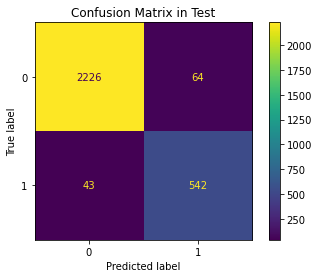

In [13]:
# Automatically select the best model

from numpy import unravel_index
best_index=unravel_index(accuracy_grid.argmax(),  accuracy_grid.shape)
decision_tree_best= DecisionTreeClassifier(grid_search[1][best_index[0]],"yes")
decision_tree_best.fit(np_train_data,np_label_train,grid_search[0][best_index[1]])
y_pred= decision_tree_best.predict(np_test_data)

print("--------------- TOTAL ACCURACY -------------------")
acc= test_accuracy(np_label_test,y_pred)
print("********* CLASS BASED ACCURACY********************")
class_accuracy(decision_tree_best,np_test_data,np_label_test)
confusion_matrix_plot(np_label_test,y_pred)